In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf

import yfinance as yf

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
import itertools

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

from scipy.stats import chi2
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')

Yfinance library is used to download data straight from Yahoo Finance. We need to choose ticker - this is the share we want to download and start and end date of period we would like to analyze.

In [2]:
df = yf.download('TWTR', start = '2013-11-08', end = '2022-05-10')

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2013-11-08  45.930000  46.939999  40.689999  41.650002  41.650002  27925300
2013-11-11  40.500000  43.000000  39.400002  42.900002  42.900002  16113900
2013-11-12  43.660000  43.779999  41.830002  41.900002  41.900002   6316700
2013-11-13  41.029999  42.869999  40.759998  42.599998  42.599998   8688300
2013-11-14  42.340000  45.669998  42.240002  44.689999  44.689999  11099400

As we will be working with stock prices, it's important to keep in mind, that the stock market is closed for weekend, therefore we will have missing values for these days. To fix that we can use asfres function equal 'b' for business days and fillna, mthod ffill, which  takes a previous value to fill a missing value.

In [4]:
df = df.asfreq(freq='b')
df = df.fillna(method = 'ffill')
df

Open       High        Low      Close  Adj Close      Volume
Date                                                                         
2013-11-08  45.930000  46.939999  40.689999  41.650002  41.650002  27925300.0
2013-11-11  40.500000  43.000000  39.400002  42.900002  42.900002  16113900.0
2013-11-12  43.660000  43.779999  41.830002  41.900002  41.900002   6316700.0
2013-11-13  41.029999  42.869999  40.759998  42.599998  42.599998   8688300.0
2013-11-14  42.340000  45.669998  42.240002  44.689999  44.689999  11099400.0
...               ...        ...        ...        ...        ...         ...
2022-05-03  49.150002  49.480000  48.750000  48.869999  48.869999  24773000.0
2022-05-04  48.799999  49.250000  48.340000  49.060001  49.060001  28443000.0
2022-05-05  50.529999  51.209999  49.810001  50.360001  50.360001  60506900.0
2022-05-06  49.959999  50.290001  49.500000  49.799999  49.799999  23403200.0
2022-05-09  49.299999  49.439999  47.630001  47.959999  47.959999  37706800.0

[2217 rows x 6 columns]

In [5]:
df.reset_index(inplace = True)

Close and Adj Close features have the same values, therefore we can drop one of them.

In [6]:
df = df.drop(columns = 'Adj Close')

In [7]:
df

Date       Open       High        Low      Close      Volume
0    2013-11-08  45.930000  46.939999  40.689999  41.650002  27925300.0
1    2013-11-11  40.500000  43.000000  39.400002  42.900002  16113900.0
2    2013-11-12  43.660000  43.779999  41.830002  41.900002   6316700.0
3    2013-11-13  41.029999  42.869999  40.759998  42.599998   8688300.0
4    2013-11-14  42.340000  45.669998  42.240002  44.689999  11099400.0
...         ...        ...        ...        ...        ...         ...
2212 2022-05-03  49.150002  49.480000  48.750000  48.869999  24773000.0
2213 2022-05-04  48.799999  49.250000  48.340000  49.060001  28443000.0
2214 2022-05-05  50.529999  51.209999  49.810001  50.360001  60506900.0
2215 2022-05-06  49.959999  50.290001  49.500000  49.799999  23403200.0
2216 2022-05-09  49.299999  49.439999  47.630001  47.959999  37706800.0

[2217 rows x 6 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2217 entries, 0 to 2216
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2217 non-null   datetime64[ns]
 1   Open    2217 non-null   float64       
 2   High    2217 non-null   float64       
 3   Low     2217 non-null   float64       
 4   Close   2217 non-null   float64       
 5   Volume  2217 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 104.0 KB


We will extract weeks, months numbers, days of a week and days of a month to plot different graphs.

In [9]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.strftime('%Y-%m')
df['Week'] = df['Date'].dt.week
df['Month_n'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Day'] = df['Date'].dt.day

In [10]:
df.head()

Date       Open       High        Low      Close      Volume  Year  \
0 2013-11-08  45.930000  46.939999  40.689999  41.650002  27925300.0  2013   
1 2013-11-11  40.500000  43.000000  39.400002  42.900002  16113900.0  2013   
2 2013-11-12  43.660000  43.779999  41.830002  41.900002   6316700.0  2013   
3 2013-11-13  41.029999  42.869999  40.759998  42.599998   8688300.0  2013   
4 2013-11-14  42.340000  45.669998  42.240002  44.689999  11099400.0  2013   

     Month  Week  Month_n  DayOfWeek  Day  
0  2013-11    45       11          4    8  
1  2013-11    46       11          0   11  
2  2013-11    46       11          1   12  
3  2013-11    46       11          2   13  
4  2013-11    46       11          3   14

We want to see how stocks volume have been changing yearly, to see if there's any anomalies presented.

In [11]:
fig = px.line(df, x="Date", y="Volume", title="Volume")
fig.show()

In [12]:
df.set_index('Date')

Open       High        Low      Close      Volume  Year  \
Date                                                                       
2013-11-08  45.930000  46.939999  40.689999  41.650002  27925300.0  2013   
2013-11-11  40.500000  43.000000  39.400002  42.900002  16113900.0  2013   
2013-11-12  43.660000  43.779999  41.830002  41.900002   6316700.0  2013   
2013-11-13  41.029999  42.869999  40.759998  42.599998   8688300.0  2013   
2013-11-14  42.340000  45.669998  42.240002  44.689999  11099400.0  2013   
...               ...        ...        ...        ...         ...   ...   
2022-05-03  49.150002  49.480000  48.750000  48.869999  24773000.0  2022   
2022-05-04  48.799999  49.250000  48.340000  49.060001  28443000.0  2022   
2022-05-05  50.529999  51.209999  49.810001  50.360001  60506900.0  2022   
2022-05-06  49.959999  50.290001  49.500000  49.799999  23403200.0  2022   
2022-05-09  49.299999  49.439999  47.630001  47.959999  37706800.0  2022   

              Month  Week  Month_n  DayOfWeek  Day  
Date                                                
2013-11-08  2013-11    45       11          4    8  
2013-11-11  2013-11    46       11          0   11  
2013-11-12  2013-11    46       11          1   12  
2013-11-13  2013-11    46       11          2   13  
2013-11-14  2013-11    46       11          3   14  
...             ...   ...      ...        ...  ...  
2022-05-03  2022-05    18        5          1    3  
2022-05-04  2022-05    18        5          2    4  
2022-05-05  2022-05    18        5          3    5  
2022-05-06  2022-05    18        5          4    6  
2022-05-09  2022-05    19        5          0    9  

[2217 rows x 11 columns]

In [13]:
df.loc[df['Volume'].argmax()]

Date         2022-04-04 00:00:00
Open                   47.869999
High                   51.369999
Low                    46.860001
Close                  49.970001
Volume               268465400.0
Year                        2022
Month                    2022-04
Week                          14
Month_n                        4
DayOfWeek                      0
Day                            4
Name: 2191, dtype: object

The biggest spike in volume is represented the day of April 4th 2022. This is the day when Elon Musk offered to buy Twitter.

In [14]:
df['Total Traded'] = df['Close']*df['Volume']

In [15]:
df

Date       Open       High        Low      Close      Volume  Year  \
0    2013-11-08  45.930000  46.939999  40.689999  41.650002  27925300.0  2013   
1    2013-11-11  40.500000  43.000000  39.400002  42.900002  16113900.0  2013   
2    2013-11-12  43.660000  43.779999  41.830002  41.900002   6316700.0  2013   
3    2013-11-13  41.029999  42.869999  40.759998  42.599998   8688300.0  2013   
4    2013-11-14  42.340000  45.669998  42.240002  44.689999  11099400.0  2013   
...         ...        ...        ...        ...        ...         ...   ...   
2212 2022-05-03  49.150002  49.480000  48.750000  48.869999  24773000.0  2022   
2213 2022-05-04  48.799999  49.250000  48.340000  49.060001  28443000.0  2022   
2214 2022-05-05  50.529999  51.209999  49.810001  50.360001  60506900.0  2022   
2215 2022-05-06  49.959999  50.290001  49.500000  49.799999  23403200.0  2022   
2216 2022-05-09  49.299999  49.439999  47.630001  47.959999  37706800.0  2022   

        Month  Week  Month_n  DayOfWeek  Day  Total Traded  
0     2013-11    45       11          4    8  1.163089e+09  
1     2013-11    46       11          0   11  6.912863e+08  
2     2013-11    46       11          1   12  2.646697e+08  
3     2013-11    46       11          2   13  3.701216e+08  
4     2013-11    46       11          3   14  4.960322e+08  
...       ...   ...      ...        ...  ...           ...  
2212  2022-05    18        5          1    3  1.210656e+09  
2213  2022-05    18        5          2    4  1.395414e+09  
2214  2022-05    18        5          3    5  3.047128e+09  
2215  2022-05    18        5          4    6  1.165479e+09  
2216  2022-05    19        5          0    9  1.808418e+09  

[2217 rows x 13 columns]

In [16]:
fig = px.line(df, x='Date', y='Total Traded',title='Total Traded, $')
fig.show()

In [17]:
df['Total Traded,B'] = df['Total Traded']/1000000000

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2217 entries, 0 to 2216
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            2217 non-null   datetime64[ns]
 1   Open            2217 non-null   float64       
 2   High            2217 non-null   float64       
 3   Low             2217 non-null   float64       
 4   Close           2217 non-null   float64       
 5   Volume          2217 non-null   float64       
 6   Year            2217 non-null   int64         
 7   Month           2217 non-null   object        
 8   Week            2217 non-null   int64         
 9   Month_n         2217 non-null   int64         
 10  DayOfWeek       2217 non-null   int64         
 11  Day             2217 non-null   int64         
 12  Total Traded    2217 non-null   float64       
 13  Total Traded,B  2217 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(5), object(1)
me

In [19]:
df.set_index('Date', inplace = True)

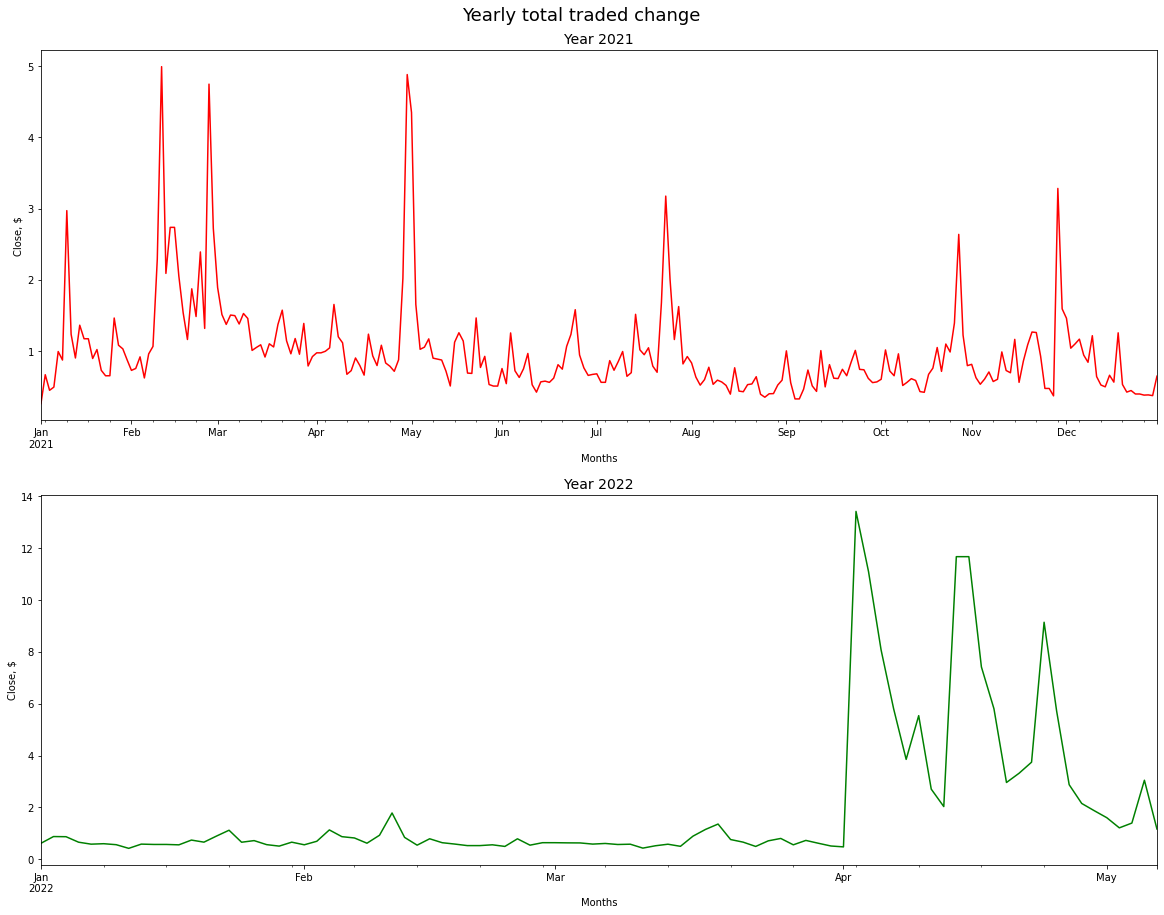

In [20]:
# Defining plots and their size
f, axes = plt.subplots(2, figsize=(20,15))

df['Total Traded,B'].iloc[1865:2125].plot(color='r', ax=axes[0])
axes[0].set_title('Year 2021', fontsize=14)


df['Total Traded,B'].iloc[2126:2216].plot(color='g', ax=axes[1])
axes[1].set_title('Year 2022', fontsize=14, y=1)

# Title 
plt.suptitle('Yearly total traded change', fontsize=18, y=0.92)
plt.savefig('Yearly total traded change.png', dpi=80, bbox_inches='tight')
axes[0].set(xlabel="Months",ylabel="Close, $")
axes[1].set(xlabel="Months",ylabel="Close, $")

plt.show()

In [21]:
df

Open       High        Low      Close      Volume  Year  \
Date                                                                       
2013-11-08  45.930000  46.939999  40.689999  41.650002  27925300.0  2013   
2013-11-11  40.500000  43.000000  39.400002  42.900002  16113900.0  2013   
2013-11-12  43.660000  43.779999  41.830002  41.900002   6316700.0  2013   
2013-11-13  41.029999  42.869999  40.759998  42.599998   8688300.0  2013   
2013-11-14  42.340000  45.669998  42.240002  44.689999  11099400.0  2013   
...               ...        ...        ...        ...         ...   ...   
2022-05-03  49.150002  49.480000  48.750000  48.869999  24773000.0  2022   
2022-05-04  48.799999  49.250000  48.340000  49.060001  28443000.0  2022   
2022-05-05  50.529999  51.209999  49.810001  50.360001  60506900.0  2022   
2022-05-06  49.959999  50.290001  49.500000  49.799999  23403200.0  2022   
2022-05-09  49.299999  49.439999  47.630001  47.959999  37706800.0  2022   

              Month  Week  Month_n  DayOfWeek  Day  Total Traded  \
Date                                                               
2013-11-08  2013-11    45       11          4    8  1.163089e+09   
2013-11-11  2013-11    46       11          0   11  6.912863e+08   
2013-11-12  2013-11    46       11          1   12  2.646697e+08   
2013-11-13  2013-11    46       11          2   13  3.701216e+08   
2013-11-14  2013-11    46       11          3   14  4.960322e+08   
...             ...   ...      ...        ...  ...           ...   
2022-05-03  2022-05    18        5          1    3  1.210656e+09   
2022-05-04  2022-05    18        5          2    4  1.395414e+09   
2022-05-05  2022-05    18        5          3    5  3.047128e+09   
2022-05-06  2022-05    18        5          4    6  1.165479e+09   
2022-05-09  2022-05    19        5          0    9  1.808418e+09   

            Total Traded,B  
Date                        
2013-11-08        1.163089  
2013-11-11        0.691286  
2013-11-12        0.264670  
2013-11-13        0.370122  
2013-11-14        0.496032  
...                    ...  
2022-05-03        1.210656  
2022-05-04        1.395414  
2022-05-05        3.047128  
2022-05-06        1.165479  
2022-05-09        1.808418  

[2217 rows x 13 columns]

In [22]:
cf.go_offline()
Twitter = df[['Open', 'High', 'Low', 'Close']].loc['2013-11-08':'2022-05-10']
Twitter.iplot(kind='candle', title = 'Twitter stock daily prices, $')

In [23]:
cf.go_offline()
Twitter = df[['Open', 'High', 'Low', 'Close']].loc['2021-05-10':'2022-05-10']
Twitter.iplot(kind='candle')

We will check how our times series are distributed.

<AxesSubplot:xlabel='Close', ylabel='Density'>

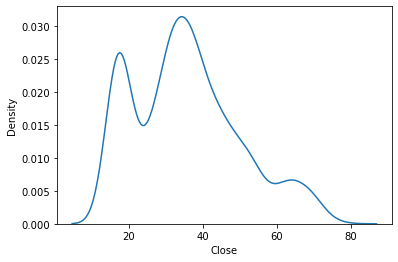

In [24]:
sns.distplot(df.Close, hist=False)

In [25]:
df.reset_index(inplace = True)
df = df.resample('M', on='Date').mean()
df.head()

Open       High        Low      Close        Volume    Year  \
Date                                                                           
2013-11-30  41.915000  42.873125  40.648125  41.708125  9.876244e+06  2013.0   
2013-12-31  55.081818  57.522727  53.723636  56.180000  2.777881e+07  2013.0   
2014-01-31  62.064783  63.450435  60.360869  61.699565  2.086727e+07  2014.0   
2014-02-28  57.124500  58.179501  55.964000  57.027999  1.802012e+07  2014.0   
2014-03-31  51.766667  52.418095  50.541905  51.211905  9.274548e+06  2014.0   

                 Week  Month_n  DayOfWeek        Day  Total Traded  \
Date                                                                 
2013-11-30  46.875000     11.0   2.125000  19.250000  4.121156e+08   
2013-12-31  46.000000     12.0   1.863636  15.954545  1.690897e+09   
2014-01-31   3.173913      1.0   2.130435  16.347826  1.293776e+09   
2014-02-28   7.500000      2.0   2.000000  15.500000  1.017014e+09   
2014-03-31  11.619048      3.0   1.904762  16.238095  4.696537e+08   

            Total Traded,B  
Date                        
2013-11-30        0.412116  
2013-12-31        1.690897  
2014-01-31        1.293776  
2014-02-28        1.017014  
2014-03-31        0.469654

Text(0.5, 1.0, 'Monthly Twitter prices')

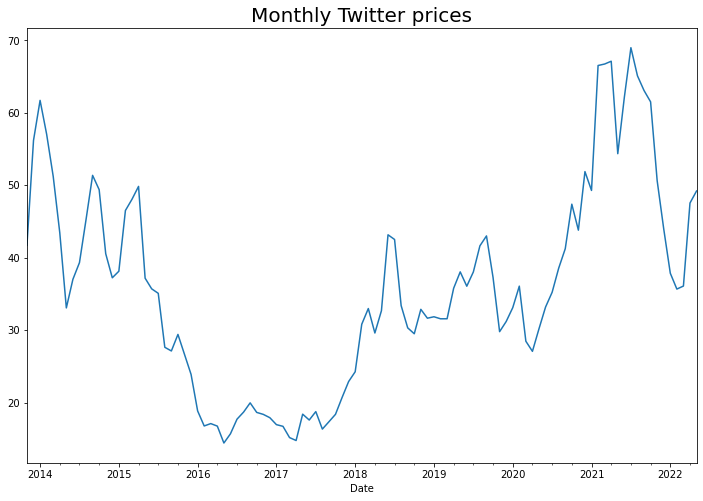

In [26]:
df.Close.plot(figsize=(12,8))
plt.title('Monthly Twitter prices', size = 20)

### Stationarity check

Check if the data is stationary, before applying ARIMA model. It also an important step to decide what model we need to use.

In [27]:
sts.adfuller(df.Close)

(-0.8969131549974729,
 0.7889872602126784,
 11,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 526.7528249706529)

### Trend/seasonality/irregularity check

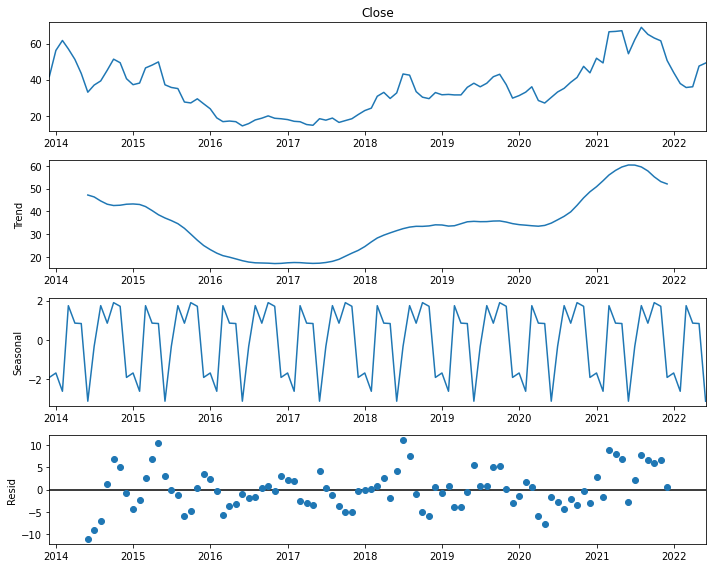

In [28]:
plt.rcParams['figure.figsize'] = (10,8)
s_dec_additive = seasonal_decompose(df.Close, model='additive')
s_dec_additive.plot()
plt.show()

We can observe trend as well as seasonality.

### Differencing

To make time series stationary, we need to difference them.

In [31]:
df['Returns'] = df.Close.diff(1)

In [32]:
df = df[2:]
df

Open       High        Low      Close        Volume    Year  \
Date                                                                           
2014-01-31  62.064783  63.450435  60.360869  61.699565  2.086727e+07  2014.0   
2014-02-28  57.124500  58.179501  55.964000  57.027999  1.802012e+07  2014.0   
2014-03-31  51.766667  52.418095  50.541905  51.211905  9.274548e+06  2014.0   
2014-04-30  43.699545  44.690454  42.401363  43.440454  1.370641e+07  2014.0   
2014-05-31  33.425000  34.060909  32.505000  33.064545  3.487166e+07  2014.0   
...               ...        ...        ...        ...           ...     ...   
2022-01-31  38.054763  38.890952  37.111905  37.854761  1.772836e+07  2022.0   
2022-02-28  35.571000  36.454500  34.842000  35.665500  2.077006e+07  2022.0   
2022-03-31  36.015217  36.829130  35.366956  36.081739  1.864147e+07  2022.0   
2022-04-30  47.918095  49.188095  46.324286  47.537143  1.201944e+08  2022.0   
2022-05-31  49.406666  49.904999  48.766667  49.198333  3.457350e+07  2022.0   

                 Week  Month_n  DayOfWeek        Day  Total Traded  \
Date                                                                 
2014-01-31   3.173913      1.0   2.130435  16.347826  1.293776e+09   
2014-02-28   7.500000      2.0   2.000000  15.500000  1.017014e+09   
2014-03-31  11.619048      3.0   1.904762  16.238095  4.696537e+08   
2014-04-30  15.909091      4.0   1.954545  15.318182  5.875347e+08   
2014-05-31  20.272727      5.0   2.136364  16.045455  1.133556e+09   
...               ...      ...        ...        ...           ...   
2022-01-31   2.619048      1.0   1.904762  16.238095  6.655771e+08   
2022-02-28   6.700000      2.0   2.000000  13.900000  7.438820e+08   
2022-03-31  11.000000      3.0   2.000000  16.000000  6.741414e+08   
2022-04-30  15.380952      4.0   2.095238  15.761905  5.777249e+09   
2022-05-31  18.166667      5.0   1.666667   4.833333  1.704910e+09   

            Total Traded,B    Returns  
Date                                   
2014-01-31        1.293776   5.519565  
2014-02-28        1.017014  -4.671566  
2014-03-31        0.469654  -5.816095  
2014-04-30        0.587535  -7.771450  
2014-05-31        1.133556 -10.375909  
...                    ...        ...  
2022-01-31        0.665577  -6.110021  
2022-02-28        0.743882  -2.189262  
2022-03-31        0.674141   0.416239  
2022-04-30        5.777249  11.455404  
2022-05-31        1.704910   1.661190  

[101 rows x 13 columns]

Plot below demonstrates comparisson of original price change and differenced price.

Text(0.5, 1.0, 'Monthly Twitter prices')

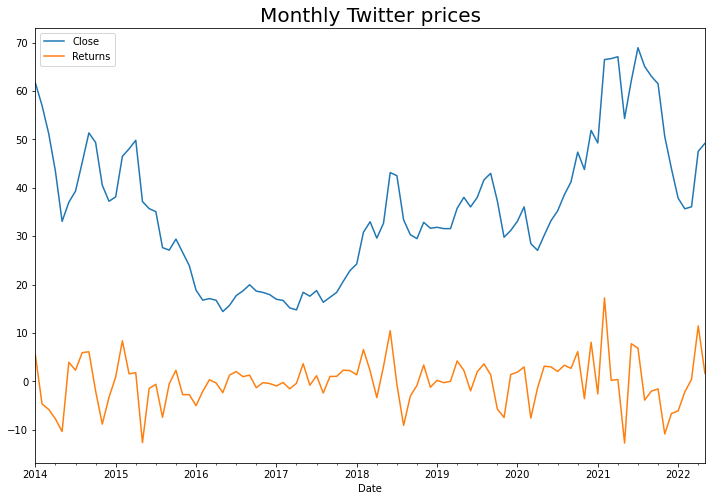

In [33]:
df[['Close','Returns']].plot(figsize=(12,8))
plt.title('Monthly Twitter prices', size = 20)

### ACF Returns

Deciding the number of lags for AR and MA. I equals 1 (differencing)

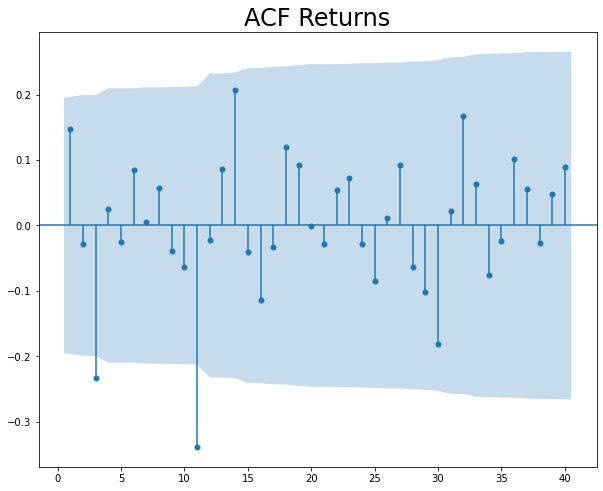

In [34]:
sgt.plot_acf(df.Returns, lags = 40, zero=False)
plt.title('ACF Returns', size =24)
plt.show()

### PACF Returns

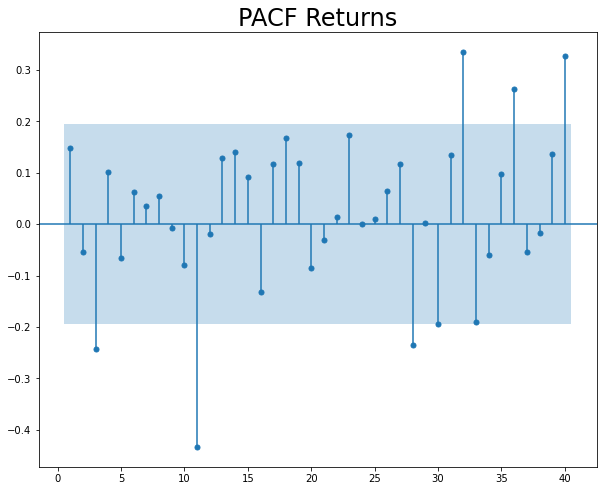

In [35]:
sgt.plot_pacf(df.Returns, lags = 40, zero=False, method=('ols'))
plt.title('PACF Returns', size =24)
plt.show()

In [36]:
train = df.Close.iloc[:70]
test = df.Close.iloc[70:]
print(train.shape, test.shape)

(70,) (31,)


We will run a loop through p=d=q in range (0,2) to select the best order for the better model perfomancce with the lowest AIC.

In [37]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [38]:
def AIC_PDQS(df):
    ans = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_invertibility=False)
                results = mod.fit()
                ans.append([param,param_seasonal,results.aic])
                print('SARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            except:
                   continue  

    ans_df = pd.DataFrame(ans, columns = ['pdq','PDQ','AIC'])
    print(ans_df.loc[ans_df['AIC'].idxmin()])
    return 

In [39]:
AIC_PDQS(df.Close)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1024.6269288549652
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:946.6511025515073
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:747.1356537245629
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:747.5380006096008
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:873.4049752278403
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:874.0867212818745
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:747.9522758840731
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:743.7002443291249
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:909.3794441511905
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:835.7243559274165
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:666.4626472877087
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:666.6530369271073
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:778.2818872233139
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:779.0696191521433
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:667.1601183769811
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:662.5986133601992
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:603.3963382950152
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:605.31272

SARIMA (1, 1, 0)(0, 1, 1, 12) is the best model selected. We will also try SARIMA (3, 1, 3)((3, 1, 3, 12) to see if it perfoms better.

In [40]:
model=sm.tsa.statespace.SARIMAX(df.Close,order=(1, 1, 0),seasonal_order=(0,1,1,12),enforce_invertibility=False)
results=model.fit()

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  101
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -272.541
Date:                              Sat, 28 May 2022   AIC                            551.081
Time:                                      17:29:02   BIC                            558.513
Sample:                                  01-31-2014   HQIC                           554.076
                                       - 05-31-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2589      0.126      2.060      0.039       0.013       0.505
ma.S.L12      -1.0001    200.877     -0.005      0.996    -394.712     392.712
sigma2        21.4647   4313.377      0.005      0.996   -8432.598    8475.527
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.86   Prob(JB):                         0.39
Heteroskedasticity (H):               1.89   Skew:                             0.30
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
model_1=sm.tsa.statespace.SARIMAX(df.Close,order=(3, 1, 3),seasonal_order=(3,1,3,12), enforce_invertibility=False)
results_1=model_1.fit()
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  101
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -263.107
Date:                            Sat, 28 May 2022   AIC                            552.214
Time:                                    17:29:05   BIC                            584.419
Sample:                                01-31-2014   HQIC                           565.188
                                     - 05-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2583      0.635     -0.407      0.684      -1.504       0.987
ar.L2          0.2334      0.691      0.338      0.736      -1.121       1.588
ar.L3         -0.3874      0.523     -0.740      0.459      -1.413       0.638
ma.L1          0.4921      0.644      0.764      0.445      -0.771       1.755
ma.L2         -0.1479      0.805     -0.184      0.854      -1.725       1.429
ma.L3          0.1120      0.597      0.187      0.851      -1.059       1.283
ar.S.L12      -0.3854      0.601     -0.642      0.521      -1.563       0.792
ar.S.L24      -0.5177      0.831     -0.623      0.533      -2.146       1.111
ar.S.L36       0.3564      0.512      0.697      0.486      -0.646       1.359
ma.S.L12      -0.5622     22.320     -0.025      0.980     -44.308      43.184
ma.S.L24       0.5675     78.520      0.007      0.994    -153.328     154.463
ma.S.L36      -0.9999    120.296     -0.008      0.993    -236.777     234.777
sigma2        13.2141   1596.565      0.008      0.993   -3115.996    3142.425
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.91
Prob(Q):                              0.70   Prob(JB):                         0.38
Heteroskedasticity (H):               1.50   Skew:                             0.36
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Important step before making forecast is to make sure, that our residuals are white noise.

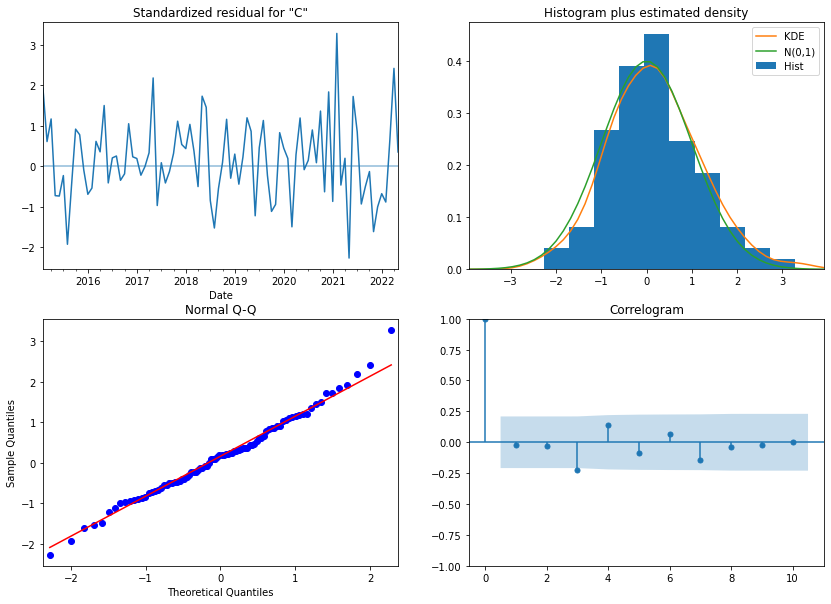

In [43]:
results.plot_diagnostics(figsize=(14,10));

Making forecast on testing data:

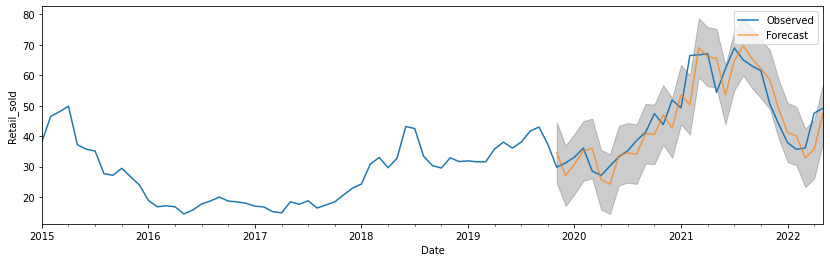

In [44]:
start = len(train)
end   = len(train) + len(test) - 1
predictions = results.get_prediction(start=start, dynamic=False)

pred_ci = predictions.conf_int()
ax = df.Close['2015':].plot(label='Observed')
predictions.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

Making prediction for the next 12 months.

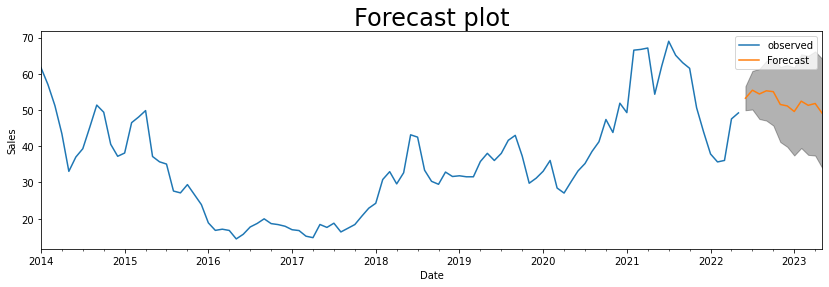

In [45]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int(alpha=0.5)
ax = df.Close.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast plot', size =24)
plt.legend()
plt.show()

### Evaluation

To evaluate models perfomance we will ise Root Mean Squared Error. Closer it to zero - the better result is.

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
y_forecasted = predictions.predicted_mean
y_truth = test

rmse = lambda act, pred: np.sqrt(mean_squared_error(act, pred))

print(f'RMSE: {rmse(y_truth, y_forecasted)}')
print(f'MAPE: {mean_absolute_percentage_error(y_truth, y_forecasted)}')

RMSE: 5.977875523919464
MAPE: 0.10381256724808934


Checking last 10 forecasted values to compare them with testing values.

In [47]:
y_forecasted = predictions.predicted_mean
y_forecasted.tail(10)

Date
2021-08-31    69.704894
2021-09-30    65.536431
2021-10-31    62.150170
2021-11-30    58.622297
2021-12-31    48.936036
2022-01-31    41.211141
2022-02-28    40.013130
2022-03-31    32.856046
2022-04-30    35.671490
2022-05-31    47.471973
Freq: M, Name: predicted_mean, dtype: float64

In [48]:
test.tail(10)

Date
2021-08-31    65.086363
2021-09-30    63.061819
2021-10-31    61.496667
2021-11-30    50.625000
2021-12-31    43.964783
2022-01-31    37.854761
2022-02-28    35.665500
2022-03-31    36.081739
2022-04-30    47.537143
2022-05-31    49.198333
Freq: M, Name: Close, dtype: float64

In [49]:
pred_ci.head(12)

lower Close  upper Close
2022-06-30    49.932424    56.561749
2022-07-31    50.131871    60.790192
2022-08-31    47.509738    61.325206
2022-09-30    47.075328    63.512196
2022-10-31    45.697612    64.406049
2022-11-30    41.153723    61.889639
2022-12-31    39.825565    62.408356
2023-01-31    37.436607    61.725165
2023-02-28    39.504216    65.368602
2023-03-31    37.616754    64.966333
2023-04-30    37.416414    66.174589
2023-05-31    34.036170    64.137097

These are prediction for the next 12 months.

In [50]:
forecast = pred_uc.predicted_mean
forecast.head(12)

2022-06-30    53.247086
2022-07-31    55.461031
2022-08-31    54.417472
2022-09-30    55.293762
2022-10-31    55.051831
2022-11-30    51.521681
2022-12-31    51.116960
2023-01-31    49.580886
2023-02-28    52.436409
2023-03-31    51.291543
2023-04-30    51.795501
2023-05-31    49.086634
Freq: M, Name: predicted_mean, dtype: float64